## Import the necessary software libraries:

In [1]:
!pip install gym==0.15.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.2 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.15.3-py3-none-any.whl size=1644944 sha256=7c9c8491298680515ef1f9b167c79e2926908dee9fa9e514ac9985794af32042
  Stored in directory: /root/.cache/pip/wheels/dc/4c/1c/25048a3f2e8540c60bbba0c25d8400f959205db1048431873a
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [2]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from gym import wrappers, Env, spaces
# from utils import test_agent, plot_stats, seed_everything

## Create and prepare the environment

### Create the environment

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
# class Single_Agent_UAV(Env):
#     def __init__(self, initial_UAV_state = None):
#         super(Single_Agent_UAV, self).__init__()

#         #self.initial_UAV_state = initial_UAV_state
#         self.initial_UAV_state = np.array([50,50])
#         self.UE_count = 30
#         self.Z = 20
#         self.horizontal_dist_max = 20
#         self.max_angle = 2 * math.pi
#         # self.dz_max = 20
#         self.phi_n = np.radians(42.44)  # in degrees
#         self.C_max_t = (self.Z / np.tan(self.phi_n))
#         self.boundary_x = self.boundary_y = 100.
#         self.max_episode_steps = 20 # Maximum number of steps in a single episode, after which environment returns done = True
#         self.current_episode_timestep = 0
#         self.done = False
#         self.action_step_size = self.boundary_x / 25.

#         # self.action_space_coversion_lb = np.array([0, 0])
#         # self.action_space_coversion_ub = np.array([self.horizontal_dist_max, self.max_angle])

#         # self.action_space_lb = -1 * np.ones(2)
#         # self.action_space_ub = np.ones(2)
#         self.state_space_lb = np.array([0 for i in range(self.UE_count + 2)])
#         self.state_space_ub = [self.boundary_x, self.boundary_y]
#         for i in range(self.UE_count):
#             self.state_space_ub.append(1)
#         self.state_space_ub = np.array(self.state_space_ub)
        
#         # plotting parameters
#         self.plotting_boundary_buffer = 5.
#         self.UAV_coverage_circle_color = 'lavender'
#         self.EC_concentrated_region_color = 'mistyrose'
#         self.UAV_path_color = 'green'


# #         defining action space
#         self.state_space = gym.spaces.box.Box(low = self.state_space_lb, high = self.state_space_ub)
# #         defining observation space
#         self.action_space = spaces.Discrete(9)

#         self.place_UEs(position="centered", center = None)
#         self.action_conversion()


#     def action_conversion(self):
#         self.n_actions = self.action_space.n
#         # HARDCODED FOR n=9
#         diag = (1 / math.sqrt(2))
#         self.index_to_action_mapper = [(0, 0 ), (1, 0), (diag, diag), (0, 1), (-diag, diag), (-1, 0), (-diag, -diag), (0, -1), (diag, -diag)]  # angle changes in clockwise fashion
#         return


#     def reset(self):
#         self.current_state = np.array(self.initial_UAV_state)
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state[:2], axis = 1)
#         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
#         self.current_state = np.concatenate((self.current_state[:2], rho_array))
#         self.timesteps_in_episode = 0
#         self.done = False
#         return self.current_state
    
    
#     def get_count_of_UEs_covered(self):
#         '''
#         Returns count of UEs covered under UAV's current configuration
#         '''

#         ground_UAV_state = self.current_state[:2]
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
#         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
#         M_t = rho_array.sum()

#         return M_t


#     def render(self, **kwargs):
#         '''
#         Function to visualize UAV position
#         (this function has different configurations for different use cases)
#         '''

#         if 'UAV_positions_list' in kwargs:
#             self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

#         if 'fig' not in kwargs:
#             fig, ax = plt.subplots(1, 2, figsize=(20,10))
#             ax = np.array([ax])
#             kwargs['fig'] = fig
#             kwargs['ax'] = ax
#             kwargs['i'] = 0
        
#         if 'reward' not in kwargs:
#             kwargs['reward'] = 'Not known'
#         self.render_position_plot(**kwargs)


#     def step(self, action):
#         '''
#         Takes action moving environment from current_state to next_state
#         Arguments: `action` to be taken
#         Returns: new_state, reward, done, info(=None)
#         '''
#         # action = action.numpy().flatten()
#         err_msg = f"{action!r} ({type(action)}) invalid"
#         assert self.action_space.contains(action), err_msg
#         assert self.current_state is not None, "Call reset before using step method."


#         self.timesteps_in_episode += 1
#         prev_UAV_state = self.current_state
#         _, inside_bounds = self.move(action)
#         # print(type(self.current_state), type(prev_UAV_state))
#         if not inside_bounds:
#             # MENTIONED OUTPUT IS OUT OF BOUNDS
#             self.is_done(end = True)
#             reward = -500
#             return self.current_state, reward, self.done, None

#         ground_UAV_state = self.current_state[:2]
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
#         self.current_state = np.concatenate((self.current_state[:2], rho_array))
#         M_t = rho_array.sum()  # no. of UEs served by the agent

#         reward = M_t * 10         
#         self.is_done(M_t)
        
#         return self.current_state, reward, self.done, None
    

#     def move(self, action):
#         '''
#         Helper function to step() function.
#         Clips the passed action to fit within action space bounds.
#         Calculates new state after performing the passed action, and updates UAV position accordingly. 
#         '''
# #         evaluates new state reached upon performing the move and saves it in self.current_state
#         # ACTION = [dx, dy]
#         x_next = self.current_state[0] + (self.index_to_action_mapper[action][0] * self.action_step_size)
#         y_next = self.current_state[1] + (self.index_to_action_mapper[action][1] * self.action_step_size)
        
#     # updating horizontal_direction_angle if the new move is out of boundary
#         if((x_next < 0) or (x_next > self.boundary_x) or (y_next < 0) or (y_next > self.boundary_y)):
#             # UAV REMAINS IN ITS CURRENT POSITION
#             return action, False

#         self.current_state[:2] = np.array([x_next, y_next])
#         return action, True


#     def is_done(self, M_t=0, end=False):
#         '''
#         Helper function to check if episode needs to be terminated
#         '''
#         if end == True:
#             self.done = True
#         # if M_t >= int(0.6 * self.UE_count):
#         #     self.done = True
#         elif(self.timesteps_in_episode >= self.max_episode_steps):
#             self.done = True
#         return

    
#     def select_random_state(self):
#         '''
#         Selects (and returns) random initial state (within bounds) for the UAV
#         '''
#         new_x = np.random.uniform(0.0, self.boundary_x)
#         new_y = np.random.uniform(0.0, self.boundary_y)
#         return np.array([new_x, new_y])
    

#     def place_UEs_centered(self, center = None, centered_UE_count = None):
#         '''
#         Helper function to place_UEs
#         Places `centered_UE_count` UEs within a circle with center `center` and radius `C_max_t`.
#         Places remaining UEs (UE_count - centered_UE_count) randomly inside the area barring the above circular region
#         Arguments: 
#             desired_z_coord: Z coordinate with which to calculate radius C_max_t for centering UEs
#             center: Provides center of circular region in which UEs will be scattered
#             centered_UE_count: Number of UEs to be placed within the circular region created using previous arguments
#         '''

#         if centered_UE_count is None:
#           centered_UE_count = self.UE_count
#         # focuses the UEs inside the circular region
#         radius = self.C_max_t
#         if(center == None):
#             # (x, y) co-ordinates
#             x = np.random.uniform(0, self.boundary_x)
#             y = np.random.uniform(0, self.boundary_y)
#             center = np.array([x, y])

#         r = radius * np.sqrt(np.random.uniform(size = centered_UE_count))
#         theta = np.random.uniform(size = centered_UE_count) * 2 * math.pi

#         self.UE_center = center
#         self.UE_radius = radius
        

#         self.UE_positions = np.zeros((centered_UE_count, 2))
#         self.UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
#         self.UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
#         return


#     def place_UEs_randomly(self, random_UE_count = None, **kwargs):
#         '''
#         Helper function to place_UEs
#         places `random_UE_count` UEs randomly onto the rectangular region
#         if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
#         and `exclude_radius` is excluded

#         '''

#         if random_UE_count is None:
#           random_UE_count = self.UE_count

#         # places UE_count UEs on grid randomly
#         if type(self.UE_positions) == np.ndarray:
#             self.UE_positions = self.UE_positions.tolist()

#         randomly_placed_count = 0
#         while(randomly_placed_count < random_UE_count):
#             x = np.random.uniform(0, self.boundary_x)
#             y = np.random.uniform(0, self.boundary_y)
#             coords = np.array([x, y])
#             if 'exclude_center' in kwargs:
#                 if (np.linalg.norm(coords - kwargs['exclude_center']) <= kwargs['exclude_radius']):
#                     continue
#             self.UE_positions.append(coords)
#             randomly_placed_count += 1

#         self.UE_positions = np.array(self.UE_positions)


#     def place_UEs(self, position="random", center = None):
#         '''
#         Function to place UEs onto the rectangular region
#         Arguments:
#             position: has 2 modes, "random" and "centered", representing the two configuration for scattering UEs
#             desired_z_coord: if position="centered", this argument gives height with which to calculate radius of circular region
#             center: if position="centered", this argument provides center of circular region
#         '''

#         self.UE_center = None  # initializing for non-centered generation algorithms

#         if(position=="centered"):
#             ratio = 0.65
#             centered_count = int(ratio * self.UE_count)
#             self.place_UEs_centered(center, centered_count)
#             if(self.UE_count - centered_count > 0):
#                 self.place_UEs_randomly(self.UE_count - centered_count, exclude_center = self.UE_center, exclude_radius = self.UE_radius)
#         elif(position=="random"):
#             self.place_UEs_randomly()

#         # saves in self.UE_positions
#         self.UE_positions = np.array(self.UE_positions)
#         return


#     def render_policy_plot(self, **kwargs):

#         fig, ax = plt.subplots(1, figsize=(10,10))
#         position_action_list = kwargs['position_action_list']
#         for position_action in position_action_list:
#             position = position_action[0]
#             action = position_action[1]
#             new_state = self.move(action, get_new_state=True)
#             ax.arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.09, head_length=0.1)
#         plt.show()
#         return


#     def render_bar_plot(self, ax, plot_number, idx):
#         '''
#         Plotting bar graph of each UE's fraction of tasks assigned to UAV and to EC, by the last action input given to step() function
#         '''
#         x_indices = np.arange(self.UE_count)
#         width = 0.5

#         gamma_array = (np.array(self.last_action[4:])).reshape((self.UE_count, self.EC_count))
#         gamma_zeros = (1 - gamma_array.sum(axis = 1))
        
#         ax[plot_number, idx].bar(x_indices, gamma_zeros, width=width)
#         for i in range(self.EC_count):
#             ax[plot_number, idx].bar(x_indices, gamma_array[:, i], width=width)
        
    
#     def render_position_plot(self, **kwargs):
#         '''
#         Helper function to render(), plots the current position plot on given axes. 
#         Plotting position plot of UAV's current position and coverage
#         '''
#         ax = kwargs['ax']
#         plot_number = kwargs['i']
#         idx = 0
#         reward = kwargs['reward']

#         buffer = 5.
#         ax[plot_number, idx].set_xlim(-buffer, self.boundary_x+buffer)
#         ax[plot_number, idx].set_ylim(-buffer, self.boundary_y+buffer)
#         ax[plot_number, idx].grid()
#         UE_x = self.UE_positions[:, 0]
#         UE_y = self.UE_positions[:, 1]
#         ax[plot_number, idx].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
#         ax[plot_number, idx].plot(self.current_state[0], self.current_state[1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
        
#         UAV_coverage_area = plt.Circle((self.current_state[0] , self.current_state[1] ), self.C_max_t, color = self.UAV_coverage_circle_color)
#         ax[plot_number, idx].add_artist(UAV_coverage_area)
      
#       # For testing: To plot the circle and visualize UE points inside it
#         if self.UE_center is not None:
#             Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = self.EC_concentrated_region_color)
#             ax[plot_number, idx].add_artist(Test_UE_allotment_circle)
#       # End

#         if 'learnt_policy_visualization' in kwargs:
#             position_action_list = kwargs['position_action_list']
#             for position_action in position_action_list:
#                 position = position_action[0]
#                 action = position_action[1]
#                 action = np.clip(action, self.action_space_lb, self.action_space_ub)
#                 action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
#                 print("scaled action: ", action)
#                 # print("action after scaling: ", action)
#                 new_state = self.move(action, get_new_state=True, provided_center=position)
#                 print("previous state: ", position, ", new state: ", new_state)
#                 # print("new_state: ", new_state)
#                 ax[plot_number, idx].plot(position[0], position[1], color='blue', marker='o', markersize=6, linestyle = '')
#                 ax[plot_number, idx].plot(new_state[0], new_state[1], color='orange', marker='o', markersize=6, linestyle = '')
#                 ax[plot_number, idx].arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.2, head_length=0.1)


#         ax[plot_number, idx].set_aspect(1)
#         # naming the x axis
#         ax[plot_number, idx].set_xlabel('X pos (m)')
#         # naming the y axis
#         ax[plot_number, idx].set_ylabel('Y pos (m)')
#         ax[plot_number, idx].set_title('reward: ' + str(reward))
#         # giving a title to my graph
#         # plt.title('Visually Appealing!')

#         # show a legend on the plot
#         ax[plot_number, idx].legend()
#         # plt.show()

In [5]:
class Single_Agent_UAV(Env):
    def __init__(self, initial_UAV_state = None):
        super(Single_Agent_UAV, self).__init__()

        self.UAV_count = 3
        #self.initial_UAV_state = initial_UAV_state
        self.UE_count = 200
        self.Z = 20
        self.horizontal_dist_max = 20
        self.max_angle = 2 * math.pi
        # self.dz_max = 20
        self.phi_n = np.radians(42.44)  # in degrees
        self.C_max_t = (self.Z / np.tan(self.phi_n))
        # self.D_min = (2 * C_max_t) + self.boundary_x / 25.
        self.C_max_t_array = np.array([self.C_max_t for _ in range(self.UAV_count)])
        self.boundary_x = self.boundary_y = 150.
        self.max_episode_steps = 50 # Maximum number of steps in a single episode, after which environment returns done = True
        self.current_episode_timestep = 0
        self.done = False
        self.action_step_size = self.boundary_x / 25.
        self.initial_UAV_state = self.select_random_state()
        self.current_state = self.initial_UAV_state

        # self.action_space_coversion_lb = np.array([0, 0])
        # self.action_space_coversion_ub = np.array([self.horizontal_dist_max, self.max_angle])

        # self.action_space_lb = -1 * np.ones(2)
        # self.action_space_ub = np.ones(2)
        self.state_space_lb = np.array([0, 0], dtype = np.float32)
        self.state_space_ub = np.array([self.boundary_x, self.boundary_y], dtype = np.float32)
        
        # plotting parameters
        self.plotting_boundary_buffer = 5.
        self.UAV_coverage_circle_color = 'lavender'
        self.EC_concentrated_region_color = 'mistyrose'
        self.UAV_path_color = 'green'


#         defining action space
        self.state_space = np.array([gym.spaces.box.Box(low = self.state_space_lb, high = self.state_space_ub) for i in range(self.UAV_count)])
#         defining observation space
        self.action_space = np.array([spaces.Discrete(9) for i in range(self.UAV_count)])

        self.place_UEs(position="centered", center = None)
        self.action_conversion()


    def action_conversion(self):
        self.n_actions = self.action_space[0].n
        # HARDCODED FOR n=9
        diag = (1 / math.sqrt(2))
        self.index_to_action_mapper = [(0, 0 ), (1, 0), (diag, diag), (0, 1), (-diag, diag), (-1, 0), (-diag, -diag), (0, -1), (diag, -diag)]  # angle changes in clockwise fashion
        return


    def reset(self):
        # RANDOMLY SELECTS UAV STARTING POSITION
        self.current_state = self.select_random_state()
        
        # RESETS UAV STARTING POSITION TO self.initial_UAV_state
        self.current_state = self.initial_UAV_state

        # FOLLOWING 3 LINES ARE USED IF THE STATE SPACE INVOLVES THE UE COVERED BINARY VECTOR
        # horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state[:2], axis = 1)
        # rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
        # self.current_state = np.concatenate((self.current_state[:2], rho_array))
        self.timesteps_in_episode = 0
        self.done = False
        return self.current_state
    
    
    def get_count_of_UEs_covered(self):
        '''
        Returns count of UEs covered under UAV's current configuration
        '''
        ground_UAV_state = self.current_state[:, :2]
        horizontal_dist_UE_UAV = np.array([np.linalg.norm(self.UE_positions - ground_UAV_state[i], axis = 1) for i in range(self.UAV_count)])
        rho_matrix = (horizontal_dist_UE_UAV <= (self.C_max_t_array[:, None])) * 1  # binary association vector [(n_uav x n_ue) dimensions]
        Mn_t = ((rho_matrix.sum(axis = 0) >= 1) * 1) 
        M_t = Mn_t.sum()  # total no. of UEs served by all the agent collectively
        return M_t


    def render(self, **kwargs):
        '''
        Function to visualize UAV position
        (this function has different configurations for different use cases)
        '''

        if 'UAV_positions_list' in kwargs:
            self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

        if 'fig' not in kwargs:
            fig, ax = plt.subplots(1, 2, figsize=(20,10))
            ax = np.array([ax])
            kwargs['fig'] = fig
            kwargs['ax'] = ax
            kwargs['i'] = 0
        
        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        self.render_position_plot(**kwargs)


    def step(self, action):
        '''
        Takes action moving environment from current_state to next_state
        Arguments: `action` to be taken
        Returns: new_state, reward, done, info(=None)
        '''
        # action = action.numpy().flatten()
        # print("action inside step: ", action)
        for i in range(self.UAV_count):
            err_msg = f"{action[i]!r} ({type(action[i])}) for UAV {i} invalid"
            assert self.action_space[i].contains(action[i]), err_msg
        assert self.current_state is not None, "Call reset before using step method."

        self.timesteps_in_episode += 1
        prev_UAV_state = self.current_state
        _, inside_bounds = self.move(action)
        # print(type(self.current_state), type(prev_UAV_state))
        if inside_bounds != 0:
            # MENTIONED OUTPUT IS OUT OF BOUNDS

            # self.is_done(end = True)
            reward = -1000
            return self.current_state, reward, self.done, None

        ground_UAV_state = self.current_state[:, :2]
        horizontal_dist_UE_UAV = np.array([np.linalg.norm(self.UE_positions - ground_UAV_state[i], axis = 1) for i in range(self.UAV_count)])
        rho_matrix = (horizontal_dist_UE_UAV <= (self.C_max_t_array[:, None])) * 1  # binary association vector [(n_uav x n_ue) dimensions]
        Mn_t = ((rho_matrix.sum(axis = 0) >= 1) * 1) 
        M_t = Mn_t.sum()  # total no. of UEs served by all the agent collectively

        reward = M_t * 10         
        self.is_done(M_t)

        return self.current_state, reward, self.done, None
    

    def move(self, action):
        '''
        Helper function to step() function.
        Clips the passed action to fit within action space bounds.
        Calculates new state after performing the passed action, and updates UAV position accordingly. 
        '''
#         evaluates new state reached upon performing the move and saves it in self.current_state
        # ACTION = [dx, dy]
        x_next_array = np.array([(self.current_state[i][0] + (self.index_to_action_mapper[action[i]][0] * self.action_step_size)) for i in range(self.UAV_count)], dtype=np.float32)
        y_next_array = np.array([(self.current_state[i][1] + (self.index_to_action_mapper[action[i]][1] * self.action_step_size)) for i in range(self.UAV_count)], dtype=np.float32)
        
    # updating horizontal_direction_angle if the new move is out of boundary
        positive_reward = True
        if ((x_next_array < 0).any()) or ((y_next_array < 0).any()) or ((x_next_array > self.boundary_x).any()) or ((y_next_array > self.boundary_y).any()):
            # UAV REMAINS IN ITS CURRENT POSITION
            positive_reward = False

        x_next_array = np.clip(x_next_array, a_min=np.array([0 for i in range(self.UAV_count)]), a_max=np.array([self.boundary_x for i in range(self.UAV_count)]))
        y_next_array = np.clip(y_next_array, a_min=np.array([0 for i in range(self.UAV_count)]), a_max=np.array([self.boundary_y for i in range(self.UAV_count)]))
        self.current_state[:, :2] = np.array([[x_next_array[i], y_next_array[i]] for i in range(self.UAV_count)])
        return action, positive_reward


    def is_done(self, M_t=0, end=False):
        '''
        Helper function to check if episode needs to be terminated
        '''
        if end == True:
            self.done = True
        # if M_t >= int(0.6 * self.UE_count):
        #     self.done = True
        elif(self.timesteps_in_episode >= self.max_episode_steps):
            self.done = True
        return

    
    def select_random_state(self):
        '''
        Selects (and returns) random initial state (within bounds) for the UAV
        '''
        UAV_pos_list = []
        for _ in range(self.UAV_count):
            new_x = np.random.uniform(0.0, self.boundary_x)
            new_y = np.random.uniform(0.0, self.boundary_y)
            UAV_pos_list.append(np.array([new_x, new_y]))

        return np.array(UAV_pos_list)


    def place_UEs_centered(self, center = None, centered_UE_count = None, radius = None):
        '''
        Helper function to place_UEs
        Places `centered_UE_count` UEs within a circle with center `center` and radius `C_max_t`.
        Places remaining UEs (UE_count - centered_UE_count) randomly inside the area barring the above circular region
        Arguments: 
            desired_z_coord: Z coordinate with which to calculate radius C_max_t for centering UEs
            center: Provides center of circular region in which UEs will be scattered
            centered_UE_count: Number of UEs to be placed within the circular region created using previous arguments
        '''

        if centered_UE_count is None:
          centered_UE_count = self.UE_count
        # focuses the UEs inside the circular region
        if radius is None:
            radius = (2 * self.C_max_t) / 3
        if center is None:
            # (x, y) co-ordinates
            x = np.random.uniform(0, self.boundary_x)
            y = np.random.uniform(0, self.boundary_y)
            center = np.array([x, y])

        r = radius * np.sqrt(np.random.uniform(size = centered_UE_count))
        theta = np.random.uniform(size = centered_UE_count) * 2 * math.pi

        if self.UE_center is None:
            self.UE_center = []
            self.UE_radius = []
        self.UE_center.append(center)
        self.UE_radius.append(radius)

        if self.UE_positions is None: 
            self.UE_positions = np.zeros((centered_UE_count, 2))
            self.UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
            self.UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
        else:
            current_iteration_UE_positions = np.zeros((centered_UE_count, 2))
            current_iteration_UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
            current_iteration_UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
            # print("self.UE_positions: ", self.UE_positions)
            # print("current_iteration_UE_positions: ", current_iteration_UE_positions) 
            self.UE_positions = np.concatenate((self.UE_positions, current_iteration_UE_positions))

        return


    def place_UEs_randomly(self, random_UE_count = None, **kwargs):
        '''
        Helper function to place_UEs
        places `random_UE_count` UEs randomly onto the rectangular region
        if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
        and `exclude_radius` is excluded

        '''

        if random_UE_count is None:
          random_UE_count = self.UE_count

        # places UE_count UEs on grid randomly
        if type(self.UE_positions) == np.ndarray:
            self.UE_positions = self.UE_positions.tolist()

        randomly_placed_count = 0
        while(randomly_placed_count < random_UE_count):
            x = np.random.uniform(0, self.boundary_x)
            y = np.random.uniform(0, self.boundary_y)
            coords = np.array([x, y])
            if 'exclude_center' in kwargs:
                if (np.linalg.norm(coords - kwargs['exclude_center']) <= kwargs['exclude_radius']):
                    continue
            self.UE_positions.append(coords)
            randomly_placed_count += 1

        self.UE_positions = np.array(self.UE_positions)


    def get_UE_cluster_center(self, current_cluster_radius, exclude_center_list = None, exclude_radius_list = None):
        
        buffer = 20.
        max_allowed_iterations = 10000
        idx = 0
        while True:
            if idx >= max_allowed_iterations:
                break
            idx += 1
            new_x = np.random.uniform(0.0, self.boundary_x)
            new_y = np.random.uniform(0.0, self.boundary_y)
            if exclude_center_list is not None:
                # print("exclude_center_list: ", exclude_center_list)
                # print("chosen coordinate: ", np.array([new_x, new_y]))
                chosen_center_to_excluded_centers_dist_list = np.linalg.norm(exclude_center_list - np.array([new_x, new_y]), axis = 1)
                if ((chosen_center_to_excluded_centers_dist_list <= (exclude_radius_list + current_cluster_radius + buffer)) * 1).any():
                    continue
                break

        return np.array([new_x, new_y])


    def place_UEs(self, position="random", center = None, num_centers = 3):
        '''
        Function to place UEs onto the rectangular region
        Arguments:
            position: has 2 modes, "random" and "centered", representing the two configuration for scattering UEs
            desired_z_coord: if position="centered", this argument gives height with which to calculate radius of circular region
            center: if position="centered", this argument provides center of circular region
        '''

        self.UE_center = None  # initializing for non-centered generation algorithms
        self.UE_positions = None

        if(position=="centered"):
            ratio = 0.75
            centered_count = int(ratio * self.UE_count)
            per_center_count = int(centered_count / num_centers)
            exclude_center_list = None
            exclude_radius_list = None
            for i in range(num_centers):
                current_UE_cluster_center = self.get_UE_cluster_center(self.C_max_t, exclude_center_list = exclude_center_list, exclude_radius_list = exclude_radius_list)
                # print(i, "th cluster center: ", current_UE_cluster_center)
                self.place_UEs_centered(center = current_UE_cluster_center, centered_UE_count = per_center_count)
                if exclude_center_list is None:
                    exclude_center_list = np.array([current_UE_cluster_center])
                    exclude_radius_list = np.array([self.UE_radius[-1]])
                else:
                    exclude_center_list = np.concatenate((exclude_center_list, np.array([current_UE_cluster_center])))
                    # print("exclude_radius_list: ", exclude_radius_list)
                    # print("current_radius: ", np.array(self.UE_radius[-1]))
                    exclude_radius_list = np.concatenate((exclude_radius_list, [np.array(self.UE_radius[-1])]))

            # Placing remaining UAVs randomly
            if((self.UE_count - (per_center_count * num_centers)) > 0):
                self.place_UEs_randomly(self.UE_count - (per_center_count * num_centers))
        
        elif(position=="random"):
            self.place_UEs_randomly()

        # saves in self.UE_positions
        self.UE_positions = np.array(self.UE_positions)
        return


    def render_UAV_movement_through_episode(self, **kwargs):
        '''
        Helper function to visualize UAV movement through an episode
        Arguments: A list specifying UAV positions throughout the episode
        '''

        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        
        buffer = 5.
        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.set_xlim(-buffer, self.boundary_x+buffer)
        ax.set_ylim(-buffer, self.boundary_y+buffer)
        ax.grid()
        UE_x = self.UE_positions[:, 0]
        UE_y = self.UE_positions[:, 1]
        ax.plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
        for i in range(self.UAV_count):
            ax.plot(kwargs['UAV_positions_list'][:, i, 0] , kwargs['UAV_positions_list'][:, i, 1], color=self.UAV_path_color, markersize=6, linestyle = '-') #, label = "UAV Path Color")
            ax.plot(kwargs['UAV_positions_list'][-1, i, 0], kwargs['UAV_positions_list'][-1, i, 1], color='blue', marker='x', markersize=9, linestyle = '') #, label = "UAV ending position")
            
            UAV_coverage_area = plt.Circle((kwargs['UAV_positions_list'][-1, i, 0], kwargs['UAV_positions_list'][-1, i, 1]), self.C_max_t, color = self.UAV_coverage_circle_color)
            ax.add_artist(UAV_coverage_area)
      
      # For testing: To plot the circle and visualize UE points inside it
        if self.UE_center is not None:
            for i in range(len(self.UE_center)):
                Test_UE_allotment_circle = plt.Circle((self.UE_center[i][0] , self.UE_center[i][1]), self.UE_radius[i], color = self.EC_concentrated_region_color)
                ax.add_artist(Test_UE_allotment_circle)
      # End

        ax.set_aspect(1)
        # naming the x axis
        ax.set_xlabel('X pos (m)')
        # naming the y axis
        ax.set_ylabel('Y pos (m)')
        ax.set_title('UAV movement through episode')
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax.legend()
        # plt.show()
        return


    def render_policy_plot(self, **kwargs):

        fig, ax = plt.subplots(1, figsize=(10,10))
        position_action_list = kwargs['position_action_list']
        for position_action in position_action_list:
            position = position_action[0]
            action = position_action[1]
            new_state = self.move(action, get_new_state=True)
            ax.arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.09, head_length=0.1)
        plt.show()
        return


    def render_bar_plot(self, ax, plot_number, idx):
        '''
        Plotting bar graph of each UE's fraction of tasks assigned to UAV and to EC, by the last action input given to step() function
        '''
        x_indices = np.arange(self.UE_count)
        width = 0.5

        gamma_array = (np.array(self.last_action[4:])).reshape((self.UE_count, self.EC_count))
        gamma_zeros = (1 - gamma_array.sum(axis = 1))
        
        ax[plot_number, idx].bar(x_indices, gamma_zeros, width=width)
        for i in range(self.EC_count):
            ax[plot_number, idx].bar(x_indices, gamma_array[:, i], width=width)
        
    
    def render_position_plot(self, **kwargs):
        '''
        Helper function to render(), plots the current position plot on given axes. 
        Plotting position plot of UAV's current position and coverage
        '''
        ax = kwargs['ax']
        plot_number = kwargs['i']
        idx = 0
        reward = kwargs['reward']

        buffer = 5.
        ax[plot_number, idx].set_xlim(-buffer, self.boundary_x+buffer)
        ax[plot_number, idx].set_ylim(-buffer, self.boundary_y+buffer)
        ax[plot_number, idx].grid()
        UE_x = self.UE_positions[:, 0]
        UE_y = self.UE_positions[:, 1]
        ax[plot_number, idx].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
        for i in range(self.UAV_count):
            ax[plot_number, idx].plot(self.current_state[i][0], self.current_state[i][1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
            UAV_coverage_area = plt.Circle((self.current_state[i][0] , self.current_state[i][1] ), self.C_max_t, color = self.UAV_coverage_circle_color)
            ax[plot_number, idx].add_artist(UAV_coverage_area)
      
      # For testing: To plot the circle and visualize UE points inside it
        if self.UE_center is not None:
            for i in range(len(self.UE_center)):
                # print("self.UE_radius inside render_position_plot: ", self.UE_radius)
                Test_UE_allotment_circle = plt.Circle((self.UE_center[i][0] , self.UE_center[i][1]), self.UE_radius[i], color = self.EC_concentrated_region_color)
                ax[plot_number, idx].add_artist(Test_UE_allotment_circle)
      # End

        if 'learnt_policy_visualization' in kwargs:
            position_action_list = kwargs['position_action_list']
            for position_action in position_action_list:
                position = position_action[0]
                action = position_action[1]
                action = np.clip(action, self.action_space_lb, self.action_space_ub)
                action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
                print("scaled action: ", action)
                # print("action after scaling: ", action)
                new_state = self.move(action, get_new_state=True, provided_center=position)
                print("previous state: ", position, ", new state: ", new_state)
                # print("new_state: ", new_state)
                ax[plot_number, idx].plot(position[0], position[1], color='blue', marker='o', markersize=6, linestyle = '')
                ax[plot_number, idx].plot(new_state[0], new_state[1], color='orange', marker='o', markersize=6, linestyle = '')
                ax[plot_number, idx].arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.2, head_length=0.1)


        ax[plot_number, idx].set_aspect(1)
        # naming the x axis
        ax[plot_number, idx].set_xlabel('X pos (m)')
        # naming the y axis
        ax[plot_number, idx].set_ylabel('Y pos (m)')
        ax[plot_number, idx].set_title('reward: ' + str(reward))
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax[plot_number, idx].legend()
        # plt.show()

In [6]:
env = Single_Agent_UAV()
env.reset()

array([[ 32.52032448, 134.61738265],
       [ 68.75356514,  84.73302814],
       [130.35135757, 148.30850099]])

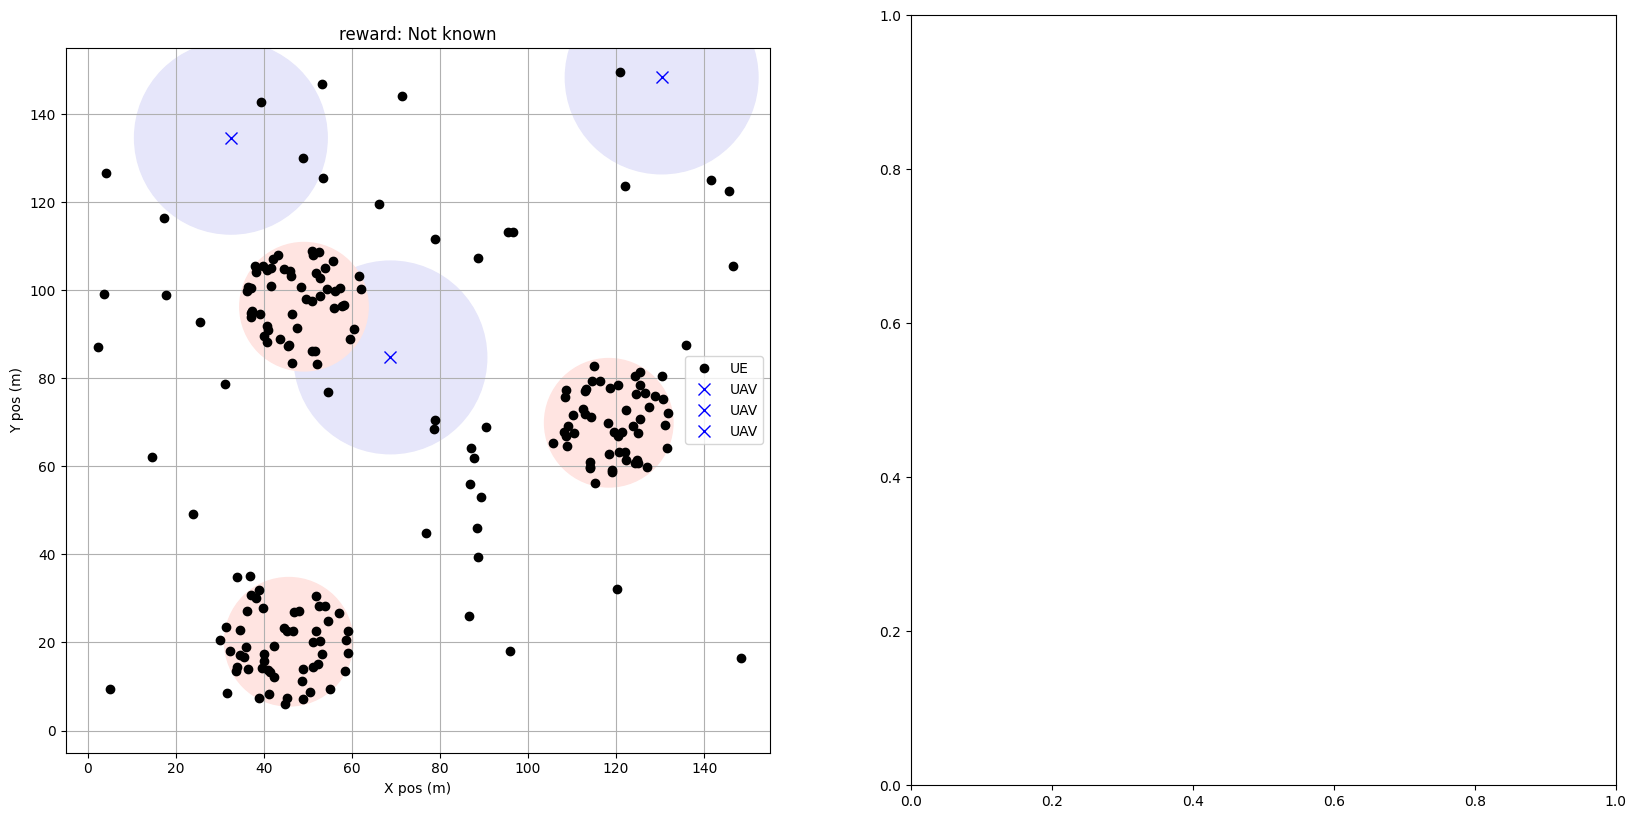

In [7]:
env.render()

In [8]:
env.get_count_of_UEs_covered()

20

In [9]:
state_dims = (env.state_space[0].shape[0] * env.UAV_count)
num_actions = env.action_space[0].n
print(f"Single Agent UAV env: State dimension: {state_dims}, Number of actions: {num_actions}")

Single Agent UAV env: State dimension: 6, Number of actions: 9


### Prepare the environment to work with PyTorch

In [10]:
state = env.reset()
action = [2 for i in range(env.UAV_count)] 
print(f"Sample state: {state}")
next_state, reward, done, _ = env.step(action)
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: [[ 32.52032448 134.61738265]
 [ 68.75356514  84.73302814]
 [130.35135757 148.30850099]]
Next state: [[ 36.76296616 138.86001587]
 [ 72.99620819  88.97566986]
 [134.59399414 150.        ]], Reward: 190, Done: False


In [11]:
action_vector = np.array([torch.tensor(0) for _ in range(env.UAV_count)])
action_vector = np.array([action_vector[i].item() for i in range(env.UAV_count)])
print(type(action_vector))

<class 'numpy.ndarray'>


In [12]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        # print("obs: ", obs)
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        # print("type of action inside wrapper: ", type(action))
        # action = action.item()
        next_state, reward, done, info = self.env.step(action)
        # print(next_state, reward, done)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [13]:
env = PreprocessEnv(env)

In [14]:
state = env.reset()
action_vector = np.array([torch.tensor(5) for _ in range(env.UAV_count)])
print(f"Sample state: {state[0]}")
next_state, reward, done, _ = env.step(action_vector)
print(f"Next state: {next_state[0]}, Reward: {reward}, Done: {done}")

Sample state: tensor([[ 36.7630, 138.8600],
        [ 72.9962,  88.9757],
        [134.5940, 150.0000]])
Next state: tensor([[ 30.7630, 138.8600],
        [ 66.9962,  88.9757],
        [128.5940, 150.0000]]), Reward: tensor([[-1000.]]), Done: tensor([[False]])


In [15]:
print(state, type(state))

tensor([[[ 36.7630, 138.8600],
         [ 72.9962,  88.9757],
         [134.5940, 150.0000]]]) <class 'torch.Tensor'>


## Create the Q-Network and policy

<br><br>

### Create the Q-Network: $\hat q(s,a| \theta)$

In [16]:
q_networks = [nn.Sequential(
    nn.Linear(state_dims, 64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, num_actions)   
) for i in range(env.UAV_count)]

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [17]:
target_q_networks = [copy.deepcopy(q_networks[i]).eval() for i in range(env.UAV_count)]

### Create the exploratory policy: $b(s)$

In [18]:
def policy(state, epsilon=0., UAV_index=0):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        flattened_state = torch.flatten(state, end_dim=-1)
        # print(flattened_state.shape)
        av = q_networks[UAV_index](flattened_state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

## Create the Experience Replay buffer

In [19]:
class ReplayMemory:
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        # print("printing batch inside sample() function: ", batch)
        return_ls = []
        for items in batch:
            # print("printing items: ", items)
            # print("printing concatenation: ", torch.cat(items))
            return_ls.append(torch.cat(items))
        # print("printing given concat operation: ", [torch.cat(items) for items in batch])
        # return [torch.cat(items) for items in batch]
        return return_ls

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

## Implement the algorithm

</br></br>

In [20]:
def deep_q_learning(q_networks, policy, episodes, alpha = 0.001,
                    batch_size = 32, gamma = 0.99, epsilon = 0.2):
    optims = [AdamW(q_networks[i].parameters(), lr= alpha) for i in range(env.UAV_count)]
    memory = ReplayMemory()
    stats= {'MSE Loss': [], 'Average_Returns': []}
    
    for episode in tqdm(range(1, episodes+1)):
        state = env.reset()
        # print("state after reset: ", state)
        # print("printing state type inside deep_q_learning() function: ", state)
        done = False
        ep_return = 0.
        print("-----------------------------episode ", episode, "-----------------------------")
        while not done:
            np_state = torch.flatten(state, end_dim=-2).numpy()
            # print("test print here: ", torch.flatten(state, end_dim=-2)[0])
            # print("policy output of 0th network: ", policy(torch.flatten(state, end_dim=-2)[0], epsilon, 0))
            # action = torch.tensor([[[policy(torch.flatten(state, end_dim=-2)[i], epsilon, i)] for i in range(env.UAV_count)]])
            action = torch.tensor([[[policy(state, epsilon, i)] for i in range(env.UAV_count)]])
            np_action = [act.item() for act in action[0]]
            # print("current state: ", state)
            # print("current action being taken: ", action)
            # print("numpy version of the action: ", np_action)
            # print("extra printing: ", action[0][0])
            # print("action inside deep_q_learning(): ", action)
            next_state, reward, done, _ = env.step(np_action)
            # print("UEs covered: ", env.get_count_of_UEs_covered())
            # print("next state: ", next_state)
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                # print("reached here")
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                # action_b = torch.flatten(action_b, end_dim = -2)
                # print("UAV action tensor: ", action_b)
                # print("state sample 0th UAV: ", state_b[:, 0, :])
                # print("action sample 0th UAV: ", action_b[:, 0, :])
                # print("Entering gradient descent:-\n state: ", state_b[:, 0, :], "action: ", action_b[:, 0, :])
                loss_sum = 0
                for i in range(env.UAV_count):
                    # qsa_input_action = 
                    # qsa_b = q_networks[i](state_b[:, i, :]).gather(1, action_b[:, i, :])
                    qsa_b = q_networks[i](torch.flatten(state_b, start_dim=1, end_dim=-1)).gather(1, action_b[:, i, :])

                    # next_qsa_b = target_q_networks[i](next_state_b[:, i, :])
                    next_qsa_b = target_q_networks[i](torch.flatten(next_state_b, start_dim=1, end_dim=-1))
                    next_qsa_b = torch.max(next_qsa_b, dim =-1, keepdim=True)[0]
                    
                    # print("printing inverse of done values: ", ~done_b)
                    target_b = reward_b + (~done_b) * gamma * next_qsa_b
                    # print("printing target: ", target_b)
                    # print("reward[0]: ", reward_b[1], "done: ", done_b[1], "gamma: ", gamma, "next_qsa_b: ", next_qsa_b[1])
                    loss = F.mse_loss(qsa_b, target_b)
                    q_networks[i].zero_grad()
                    loss.backward()
                    optims[i].step()
                    loss_sum += loss
                stats['MSE Loss'].append(loss_sum)
            
            state = next_state
            ep_return +=reward.item()
        
        print("no. of UEs covered (Reward): ", reward.item())
        stats['Average_Returns'].append(float(ep_return) / env.timesteps_in_episode)
    
        if episode % 10 ==0:
            for i in range(env.UAV_count):
                target_q_networks[i].load_state_dict(q_networks[i].state_dict())
    return stats

In [21]:
a = torch.tensor([[[1, 2, 3],
   [4, 5, 6]],
   [[7, 8, 9],
   [10, 11, 12]]])
b = torch.flatten(a, start_dim=1, end_dim=-1)
b

tensor([[ 1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12]])

In [22]:
stats = deep_q_learning(q_networks, policy, 300)

  0%|          | 0/300 [00:00<?, ?it/s]

-----------------------------episode  1 -----------------------------
no. of UEs covered (Reward):  630.0
-----------------------------episode  2 -----------------------------


  1%|          | 2/300 [00:00<00:17, 17.37it/s]

no. of UEs covered (Reward):  500.0
-----------------------------episode  3 -----------------------------
no. of UEs covered (Reward):  280.0
-----------------------------episode  4 -----------------------------


  2%|▏         | 5/300 [00:00<00:15, 19.03it/s]

no. of UEs covered (Reward):  90.0
-----------------------------episode  5 -----------------------------
no. of UEs covered (Reward):  550.0
-----------------------------episode  6 -----------------------------
no. of UEs covered (Reward):  620.0
-----------------------------episode  7 -----------------------------


  2%|▏         | 7/300 [00:00<00:30,  9.67it/s]

no. of UEs covered (Reward):  460.0
-----------------------------episode  8 -----------------------------
no. of UEs covered (Reward):  490.0
-----------------------------episode  9 -----------------------------


  3%|▎         | 9/300 [00:01<00:57,  5.10it/s]

no. of UEs covered (Reward):  460.0
-----------------------------episode  10 -----------------------------


  3%|▎         | 10/300 [00:01<01:04,  4.46it/s]

no. of UEs covered (Reward):  50.0
-----------------------------episode  11 -----------------------------


  4%|▎         | 11/300 [00:02<01:12,  4.01it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  12 -----------------------------


  4%|▍         | 12/300 [00:02<01:17,  3.72it/s]

no. of UEs covered (Reward):  50.0
-----------------------------episode  13 -----------------------------


  4%|▍         | 13/300 [00:02<01:25,  3.34it/s]

no. of UEs covered (Reward):  260.0
-----------------------------episode  14 -----------------------------


  5%|▍         | 14/300 [00:03<01:34,  3.02it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  15 -----------------------------


  5%|▌         | 15/300 [00:03<01:35,  3.00it/s]

no. of UEs covered (Reward):  150.0
-----------------------------episode  16 -----------------------------


  5%|▌         | 16/300 [00:03<01:35,  2.97it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  17 -----------------------------


  6%|▌         | 17/300 [00:04<01:37,  2.90it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  18 -----------------------------


  6%|▌         | 18/300 [00:04<01:36,  2.91it/s]

no. of UEs covered (Reward):  170.0
-----------------------------episode  19 -----------------------------


  6%|▋         | 19/300 [00:04<01:40,  2.80it/s]

no. of UEs covered (Reward):  70.0
-----------------------------episode  20 -----------------------------


  7%|▋         | 20/300 [00:05<01:39,  2.82it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  21 -----------------------------


  7%|▋         | 21/300 [00:05<01:38,  2.84it/s]

no. of UEs covered (Reward):  50.0
-----------------------------episode  22 -----------------------------


  7%|▋         | 22/300 [00:05<01:38,  2.82it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  23 -----------------------------


  8%|▊         | 23/300 [00:06<01:38,  2.80it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  24 -----------------------------


  8%|▊         | 24/300 [00:06<01:38,  2.80it/s]

no. of UEs covered (Reward):  10.0
-----------------------------episode  25 -----------------------------


  8%|▊         | 25/300 [00:07<01:38,  2.81it/s]

no. of UEs covered (Reward):  10.0
-----------------------------episode  26 -----------------------------


  9%|▊         | 26/300 [00:07<01:38,  2.78it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  27 -----------------------------


  9%|▉         | 27/300 [00:07<01:36,  2.81it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  28 -----------------------------


  9%|▉         | 28/300 [00:08<01:50,  2.47it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  29 -----------------------------


 10%|▉         | 29/300 [00:08<01:57,  2.30it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  30 -----------------------------


 10%|█         | 30/300 [00:09<02:05,  2.16it/s]

no. of UEs covered (Reward):  240.0
-----------------------------episode  31 -----------------------------


 10%|█         | 31/300 [00:09<02:12,  2.03it/s]

no. of UEs covered (Reward):  140.0
-----------------------------episode  32 -----------------------------


 11%|█         | 32/300 [00:10<02:26,  1.82it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  33 -----------------------------


 11%|█         | 33/300 [00:10<02:10,  2.05it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  34 -----------------------------


 11%|█▏        | 34/300 [00:11<02:00,  2.22it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  35 -----------------------------


 12%|█▏        | 35/300 [00:11<01:51,  2.38it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  36 -----------------------------


 12%|█▏        | 36/300 [00:11<01:44,  2.53it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  37 -----------------------------


 12%|█▏        | 37/300 [00:12<01:39,  2.64it/s]

no. of UEs covered (Reward):  330.0
-----------------------------episode  38 -----------------------------


 13%|█▎        | 38/300 [00:12<01:37,  2.70it/s]

no. of UEs covered (Reward):  60.0
-----------------------------episode  39 -----------------------------


 13%|█▎        | 39/300 [00:12<01:34,  2.76it/s]

no. of UEs covered (Reward):  60.0
-----------------------------episode  40 -----------------------------


 13%|█▎        | 40/300 [00:13<01:33,  2.78it/s]

no. of UEs covered (Reward):  80.0
-----------------------------episode  41 -----------------------------


 14%|█▎        | 41/300 [00:13<01:32,  2.80it/s]

no. of UEs covered (Reward):  90.0
-----------------------------episode  42 -----------------------------


 14%|█▍        | 42/300 [00:14<01:31,  2.81it/s]

no. of UEs covered (Reward):  460.0
-----------------------------episode  43 -----------------------------


 14%|█▍        | 43/300 [00:14<01:30,  2.83it/s]

no. of UEs covered (Reward):  70.0
-----------------------------episode  44 -----------------------------


 15%|█▍        | 44/300 [00:14<01:30,  2.83it/s]

no. of UEs covered (Reward):  90.0
-----------------------------episode  45 -----------------------------


 15%|█▌        | 45/300 [00:15<01:30,  2.83it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  46 -----------------------------


 15%|█▌        | 46/300 [00:15<01:29,  2.84it/s]

no. of UEs covered (Reward):  10.0
-----------------------------episode  47 -----------------------------


 16%|█▌        | 47/300 [00:15<01:30,  2.80it/s]

no. of UEs covered (Reward):  530.0
-----------------------------episode  48 -----------------------------


 16%|█▌        | 48/300 [00:16<01:32,  2.73it/s]

no. of UEs covered (Reward):  650.0
-----------------------------episode  49 -----------------------------


 16%|█▋        | 49/300 [00:16<01:30,  2.77it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  50 -----------------------------


 17%|█▋        | 50/300 [00:16<01:29,  2.80it/s]

no. of UEs covered (Reward):  70.0
-----------------------------episode  51 -----------------------------


 17%|█▋        | 51/300 [00:17<01:29,  2.80it/s]

no. of UEs covered (Reward):  80.0
-----------------------------episode  52 -----------------------------


 17%|█▋        | 52/300 [00:17<01:28,  2.81it/s]

no. of UEs covered (Reward):  210.0
-----------------------------episode  53 -----------------------------


 18%|█▊        | 53/300 [00:18<01:34,  2.62it/s]

no. of UEs covered (Reward):  490.0
-----------------------------episode  54 -----------------------------


 18%|█▊        | 54/300 [00:18<01:45,  2.34it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  55 -----------------------------


 18%|█▊        | 55/300 [00:19<02:02,  2.00it/s]

no. of UEs covered (Reward):  90.0
-----------------------------episode  56 -----------------------------


 19%|█▊        | 56/300 [00:19<02:14,  1.82it/s]

no. of UEs covered (Reward):  160.0
-----------------------------episode  57 -----------------------------


 19%|█▉        | 57/300 [00:20<02:48,  1.44it/s]

no. of UEs covered (Reward):  390.0
-----------------------------episode  58 -----------------------------


 19%|█▉        | 58/300 [00:22<03:34,  1.13it/s]

no. of UEs covered (Reward):  550.0
-----------------------------episode  59 -----------------------------


 20%|█▉        | 59/300 [00:23<03:53,  1.03it/s]

no. of UEs covered (Reward):  200.0
-----------------------------episode  60 -----------------------------


 20%|██        | 60/300 [00:24<03:34,  1.12it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  61 -----------------------------


 20%|██        | 61/300 [00:25<03:34,  1.11it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  62 -----------------------------


 21%|██        | 62/300 [00:25<03:25,  1.16it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  63 -----------------------------


 21%|██        | 63/300 [00:26<03:19,  1.19it/s]

no. of UEs covered (Reward):  130.0
-----------------------------episode  64 -----------------------------


 21%|██▏       | 64/300 [00:27<03:22,  1.16it/s]

no. of UEs covered (Reward):  240.0
-----------------------------episode  65 -----------------------------


 22%|██▏       | 65/300 [00:28<03:18,  1.19it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  66 -----------------------------


 22%|██▏       | 66/300 [00:29<03:15,  1.20it/s]

no. of UEs covered (Reward):  200.0
-----------------------------episode  67 -----------------------------


 22%|██▏       | 67/300 [00:29<03:05,  1.25it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  68 -----------------------------


 23%|██▎       | 68/300 [00:30<03:02,  1.27it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  69 -----------------------------


 23%|██▎       | 69/300 [00:31<03:09,  1.22it/s]

no. of UEs covered (Reward):  200.0
-----------------------------episode  70 -----------------------------


 23%|██▎       | 70/300 [00:32<02:56,  1.30it/s]

no. of UEs covered (Reward):  270.0
-----------------------------episode  71 -----------------------------


 24%|██▎       | 71/300 [00:33<03:03,  1.25it/s]

no. of UEs covered (Reward):  490.0
-----------------------------episode  72 -----------------------------


 24%|██▍       | 72/300 [00:34<03:14,  1.17it/s]

no. of UEs covered (Reward):  200.0
-----------------------------episode  73 -----------------------------


 24%|██▍       | 73/300 [00:34<03:15,  1.16it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  74 -----------------------------


 25%|██▍       | 74/300 [00:35<02:51,  1.31it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  75 -----------------------------


 25%|██▌       | 75/300 [00:35<02:36,  1.44it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  76 -----------------------------


 25%|██▌       | 76/300 [00:36<02:17,  1.63it/s]

no. of UEs covered (Reward):  220.0
-----------------------------episode  77 -----------------------------


 26%|██▌       | 77/300 [00:36<02:00,  1.84it/s]

no. of UEs covered (Reward):  510.0
-----------------------------episode  78 -----------------------------


 26%|██▌       | 78/300 [00:37<01:48,  2.05it/s]

no. of UEs covered (Reward):  260.0
-----------------------------episode  79 -----------------------------


 26%|██▋       | 79/300 [00:37<01:39,  2.23it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  80 -----------------------------


 27%|██▋       | 80/300 [00:37<01:32,  2.37it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  81 -----------------------------


 27%|██▋       | 81/300 [00:38<01:28,  2.48it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  82 -----------------------------


 27%|██▋       | 82/300 [00:38<01:25,  2.55it/s]

no. of UEs covered (Reward):  10.0
-----------------------------episode  83 -----------------------------


 28%|██▊       | 83/300 [00:38<01:23,  2.61it/s]

no. of UEs covered (Reward):  90.0
-----------------------------episode  84 -----------------------------


 28%|██▊       | 84/300 [00:39<01:21,  2.66it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  85 -----------------------------


 28%|██▊       | 85/300 [00:39<01:19,  2.70it/s]

no. of UEs covered (Reward):  490.0
-----------------------------episode  86 -----------------------------


 29%|██▊       | 86/300 [00:40<01:18,  2.74it/s]

no. of UEs covered (Reward):  70.0
-----------------------------episode  87 -----------------------------


 29%|██▉       | 87/300 [00:40<01:17,  2.75it/s]

no. of UEs covered (Reward):  80.0
-----------------------------episode  88 -----------------------------


 29%|██▉       | 88/300 [00:40<01:17,  2.73it/s]

no. of UEs covered (Reward):  350.0
-----------------------------episode  89 -----------------------------


 30%|██▉       | 89/300 [00:41<01:17,  2.72it/s]

no. of UEs covered (Reward):  430.0
-----------------------------episode  90 -----------------------------


 30%|███       | 90/300 [00:41<01:16,  2.74it/s]

no. of UEs covered (Reward):  50.0
-----------------------------episode  91 -----------------------------


 30%|███       | 91/300 [00:41<01:16,  2.72it/s]

no. of UEs covered (Reward):  50.0
-----------------------------episode  92 -----------------------------


 31%|███       | 92/300 [00:42<01:15,  2.76it/s]

no. of UEs covered (Reward):  80.0
-----------------------------episode  93 -----------------------------


 31%|███       | 93/300 [00:42<01:13,  2.80it/s]

no. of UEs covered (Reward):  520.0
-----------------------------episode  94 -----------------------------


 31%|███▏      | 94/300 [00:42<01:13,  2.78it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  95 -----------------------------


 32%|███▏      | 95/300 [00:43<01:13,  2.77it/s]

no. of UEs covered (Reward):  80.0
-----------------------------episode  96 -----------------------------


 32%|███▏      | 96/300 [00:43<01:13,  2.76it/s]

no. of UEs covered (Reward):  480.0
-----------------------------episode  97 -----------------------------


 32%|███▏      | 97/300 [00:44<01:15,  2.67it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  98 -----------------------------


 33%|███▎      | 98/300 [00:44<01:15,  2.69it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  99 -----------------------------


 33%|███▎      | 99/300 [00:44<01:13,  2.73it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  100 -----------------------------


 33%|███▎      | 100/300 [00:45<01:13,  2.73it/s]

no. of UEs covered (Reward):  480.0
-----------------------------episode  101 -----------------------------


 34%|███▎      | 101/300 [00:45<01:13,  2.71it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  102 -----------------------------


 34%|███▍      | 102/300 [00:45<01:12,  2.72it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  103 -----------------------------


 34%|███▍      | 103/300 [00:46<01:14,  2.65it/s]

no. of UEs covered (Reward):  550.0
-----------------------------episode  104 -----------------------------


 35%|███▍      | 104/300 [00:46<01:22,  2.39it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  105 -----------------------------


 35%|███▌      | 105/300 [00:47<01:28,  2.22it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  106 -----------------------------


 35%|███▌      | 106/300 [00:47<01:30,  2.13it/s]

no. of UEs covered (Reward):  570.0
-----------------------------episode  107 -----------------------------


 36%|███▌      | 107/300 [00:48<01:33,  2.05it/s]

no. of UEs covered (Reward):  200.0
-----------------------------episode  108 -----------------------------


 36%|███▌      | 108/300 [00:48<01:33,  2.06it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  109 -----------------------------


 36%|███▋      | 109/300 [00:49<01:25,  2.23it/s]

no. of UEs covered (Reward):  400.0
-----------------------------episode  110 -----------------------------


 37%|███▋      | 110/300 [00:49<01:20,  2.36it/s]

no. of UEs covered (Reward):  530.0
-----------------------------episode  111 -----------------------------


 37%|███▋      | 111/300 [00:49<01:16,  2.47it/s]

no. of UEs covered (Reward):  160.0
-----------------------------episode  112 -----------------------------


 37%|███▋      | 112/300 [00:50<01:14,  2.54it/s]

no. of UEs covered (Reward):  200.0
-----------------------------episode  113 -----------------------------


 38%|███▊      | 113/300 [00:50<01:11,  2.62it/s]

no. of UEs covered (Reward):  370.0
-----------------------------episode  114 -----------------------------


 38%|███▊      | 114/300 [00:51<01:10,  2.62it/s]

no. of UEs covered (Reward):  330.0
-----------------------------episode  115 -----------------------------


 38%|███▊      | 115/300 [00:51<01:09,  2.68it/s]

no. of UEs covered (Reward):  380.0
-----------------------------episode  116 -----------------------------


 39%|███▊      | 116/300 [00:51<01:07,  2.72it/s]

no. of UEs covered (Reward):  540.0
-----------------------------episode  117 -----------------------------


 39%|███▉      | 117/300 [00:52<01:07,  2.70it/s]

no. of UEs covered (Reward):  480.0
-----------------------------episode  118 -----------------------------


 39%|███▉      | 118/300 [00:52<01:07,  2.71it/s]

no. of UEs covered (Reward):  340.0
-----------------------------episode  119 -----------------------------


 40%|███▉      | 119/300 [00:52<01:06,  2.73it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  120 -----------------------------


 40%|████      | 120/300 [00:53<01:06,  2.71it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  121 -----------------------------


 40%|████      | 121/300 [00:53<01:06,  2.68it/s]

no. of UEs covered (Reward):  390.0
-----------------------------episode  122 -----------------------------


 41%|████      | 122/300 [00:53<01:05,  2.71it/s]

no. of UEs covered (Reward):  50.0
-----------------------------episode  123 -----------------------------


 41%|████      | 123/300 [00:54<01:07,  2.60it/s]

no. of UEs covered (Reward):  410.0
-----------------------------episode  124 -----------------------------


 41%|████▏     | 124/300 [00:54<01:07,  2.62it/s]

no. of UEs covered (Reward):  60.0
-----------------------------episode  125 -----------------------------


 42%|████▏     | 125/300 [00:55<01:06,  2.63it/s]

no. of UEs covered (Reward):  580.0
-----------------------------episode  126 -----------------------------


 42%|████▏     | 126/300 [00:55<01:05,  2.66it/s]

no. of UEs covered (Reward):  450.0
-----------------------------episode  127 -----------------------------


 42%|████▏     | 127/300 [00:55<01:05,  2.65it/s]

no. of UEs covered (Reward):  210.0
-----------------------------episode  128 -----------------------------


 43%|████▎     | 128/300 [00:56<01:04,  2.66it/s]

no. of UEs covered (Reward):  70.0
-----------------------------episode  129 -----------------------------


 43%|████▎     | 129/300 [00:56<01:04,  2.66it/s]

no. of UEs covered (Reward):  330.0
-----------------------------episode  130 -----------------------------


 43%|████▎     | 130/300 [00:57<01:03,  2.69it/s]

no. of UEs covered (Reward):  270.0
-----------------------------episode  131 -----------------------------


 44%|████▎     | 131/300 [00:57<01:02,  2.70it/s]

no. of UEs covered (Reward):  230.0
-----------------------------episode  132 -----------------------------


 44%|████▍     | 132/300 [00:57<01:02,  2.70it/s]

no. of UEs covered (Reward):  550.0
-----------------------------episode  133 -----------------------------


 44%|████▍     | 133/300 [00:58<01:01,  2.71it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  134 -----------------------------


 45%|████▍     | 134/300 [00:58<01:01,  2.71it/s]

no. of UEs covered (Reward):  80.0
-----------------------------episode  135 -----------------------------


 45%|████▌     | 135/300 [00:58<01:02,  2.65it/s]

no. of UEs covered (Reward):  530.0
-----------------------------episode  136 -----------------------------


 45%|████▌     | 136/300 [00:59<01:09,  2.38it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  137 -----------------------------


 46%|████▌     | 137/300 [00:59<01:14,  2.19it/s]

no. of UEs covered (Reward):  440.0
-----------------------------episode  138 -----------------------------


 46%|████▌     | 138/300 [01:00<01:16,  2.11it/s]

no. of UEs covered (Reward):  210.0
-----------------------------episode  139 -----------------------------


 46%|████▋     | 139/300 [01:00<01:18,  2.06it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  140 -----------------------------


 47%|████▋     | 140/300 [01:01<01:18,  2.04it/s]

no. of UEs covered (Reward):  10.0
-----------------------------episode  141 -----------------------------


 47%|████▋     | 141/300 [01:01<01:11,  2.23it/s]

no. of UEs covered (Reward):  460.0
-----------------------------episode  142 -----------------------------


 47%|████▋     | 142/300 [01:02<01:06,  2.38it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  143 -----------------------------


 48%|████▊     | 143/300 [01:02<01:03,  2.47it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  144 -----------------------------


 48%|████▊     | 144/300 [01:02<01:00,  2.57it/s]

no. of UEs covered (Reward):  220.0
-----------------------------episode  145 -----------------------------


 48%|████▊     | 145/300 [01:03<00:58,  2.64it/s]

no. of UEs covered (Reward):  550.0
-----------------------------episode  146 -----------------------------


 49%|████▊     | 146/300 [01:03<00:57,  2.68it/s]

no. of UEs covered (Reward):  140.0
-----------------------------episode  147 -----------------------------


 49%|████▉     | 147/300 [01:03<00:56,  2.71it/s]

no. of UEs covered (Reward):  130.0
-----------------------------episode  148 -----------------------------


 49%|████▉     | 148/300 [01:04<00:56,  2.71it/s]

no. of UEs covered (Reward):  170.0
-----------------------------episode  149 -----------------------------


 50%|████▉     | 149/300 [01:04<00:55,  2.71it/s]

no. of UEs covered (Reward):  270.0
-----------------------------episode  150 -----------------------------


 50%|█████     | 150/300 [01:05<00:55,  2.70it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  151 -----------------------------


 50%|█████     | 151/300 [01:05<00:54,  2.72it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  152 -----------------------------


 51%|█████     | 152/300 [01:05<00:54,  2.69it/s]

no. of UEs covered (Reward):  420.0
-----------------------------episode  153 -----------------------------


 51%|█████     | 153/300 [01:06<00:55,  2.65it/s]

no. of UEs covered (Reward):  210.0
-----------------------------episode  154 -----------------------------


 51%|█████▏    | 154/300 [01:06<00:55,  2.65it/s]

no. of UEs covered (Reward):  380.0
-----------------------------episode  155 -----------------------------


 52%|█████▏    | 155/300 [01:06<00:54,  2.66it/s]

no. of UEs covered (Reward):  350.0
-----------------------------episode  156 -----------------------------


 52%|█████▏    | 156/300 [01:07<00:53,  2.70it/s]

no. of UEs covered (Reward):  380.0
-----------------------------episode  157 -----------------------------


 52%|█████▏    | 157/300 [01:07<00:52,  2.72it/s]

no. of UEs covered (Reward):  260.0
-----------------------------episode  158 -----------------------------


 53%|█████▎    | 158/300 [01:08<00:51,  2.74it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  159 -----------------------------


 53%|█████▎    | 159/300 [01:08<00:52,  2.70it/s]

no. of UEs covered (Reward):  450.0
-----------------------------episode  160 -----------------------------


 53%|█████▎    | 160/300 [01:08<00:51,  2.69it/s]

no. of UEs covered (Reward):  440.0
-----------------------------episode  161 -----------------------------


 54%|█████▎    | 161/300 [01:09<00:51,  2.68it/s]

no. of UEs covered (Reward):  410.0
-----------------------------episode  162 -----------------------------


 54%|█████▍    | 162/300 [01:09<00:51,  2.68it/s]

no. of UEs covered (Reward):  450.0
-----------------------------episode  163 -----------------------------


 54%|█████▍    | 163/300 [01:09<00:51,  2.67it/s]

no. of UEs covered (Reward):  430.0
-----------------------------episode  164 -----------------------------


 55%|█████▍    | 164/300 [01:10<00:50,  2.69it/s]

no. of UEs covered (Reward):  470.0
-----------------------------episode  165 -----------------------------


 55%|█████▌    | 165/300 [01:10<00:50,  2.67it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  166 -----------------------------


 55%|█████▌    | 166/300 [01:11<00:49,  2.70it/s]

no. of UEs covered (Reward):  170.0
-----------------------------episode  167 -----------------------------


 56%|█████▌    | 167/300 [01:11<00:50,  2.65it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  168 -----------------------------


 56%|█████▌    | 168/300 [01:11<00:55,  2.38it/s]

no. of UEs covered (Reward):  270.0
-----------------------------episode  169 -----------------------------


 56%|█████▋    | 169/300 [01:12<00:58,  2.22it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  170 -----------------------------


 57%|█████▋    | 170/300 [01:12<01:00,  2.14it/s]

no. of UEs covered (Reward):  520.0
-----------------------------episode  171 -----------------------------


 57%|█████▋    | 171/300 [01:13<01:01,  2.09it/s]

no. of UEs covered (Reward):  360.0
-----------------------------episode  172 -----------------------------


 57%|█████▋    | 172/300 [01:14<01:03,  2.03it/s]

no. of UEs covered (Reward):  410.0
-----------------------------episode  173 -----------------------------


 58%|█████▊    | 173/300 [01:14<00:57,  2.22it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  174 -----------------------------


 58%|█████▊    | 174/300 [01:14<00:53,  2.37it/s]

no. of UEs covered (Reward):  160.0
-----------------------------episode  175 -----------------------------


 58%|█████▊    | 175/300 [01:15<00:50,  2.47it/s]

no. of UEs covered (Reward):  220.0
-----------------------------episode  176 -----------------------------


 59%|█████▊    | 176/300 [01:15<00:48,  2.57it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  177 -----------------------------


 59%|█████▉    | 177/300 [01:15<00:46,  2.63it/s]

no. of UEs covered (Reward):  530.0
-----------------------------episode  178 -----------------------------


 59%|█████▉    | 178/300 [01:16<00:45,  2.65it/s]

no. of UEs covered (Reward):  370.0
-----------------------------episode  179 -----------------------------


 60%|█████▉    | 179/300 [01:16<00:45,  2.66it/s]

no. of UEs covered (Reward):  60.0
-----------------------------episode  180 -----------------------------


 60%|██████    | 180/300 [01:16<00:44,  2.70it/s]

no. of UEs covered (Reward):  120.0
-----------------------------episode  181 -----------------------------


 60%|██████    | 181/300 [01:17<00:43,  2.73it/s]

no. of UEs covered (Reward):  520.0
-----------------------------episode  182 -----------------------------


 61%|██████    | 182/300 [01:17<00:42,  2.76it/s]

no. of UEs covered (Reward):  530.0
-----------------------------episode  183 -----------------------------


 61%|██████    | 183/300 [01:17<00:42,  2.75it/s]

no. of UEs covered (Reward):  480.0
-----------------------------episode  184 -----------------------------


 61%|██████▏   | 184/300 [01:18<00:41,  2.78it/s]

no. of UEs covered (Reward):  200.0
-----------------------------episode  185 -----------------------------


 62%|██████▏   | 185/300 [01:18<00:40,  2.82it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  186 -----------------------------


 62%|██████▏   | 186/300 [01:19<00:40,  2.81it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  187 -----------------------------


 62%|██████▏   | 187/300 [01:19<00:39,  2.85it/s]

no. of UEs covered (Reward):  520.0
-----------------------------episode  188 -----------------------------


 63%|██████▎   | 188/300 [01:19<00:39,  2.87it/s]

no. of UEs covered (Reward):  460.0
-----------------------------episode  189 -----------------------------


 63%|██████▎   | 189/300 [01:20<00:38,  2.87it/s]

no. of UEs covered (Reward):  420.0
-----------------------------episode  190 -----------------------------


 63%|██████▎   | 190/300 [01:20<00:38,  2.84it/s]

no. of UEs covered (Reward):  530.0
-----------------------------episode  191 -----------------------------


 64%|██████▎   | 191/300 [01:20<00:38,  2.85it/s]

no. of UEs covered (Reward):  460.0
-----------------------------episode  192 -----------------------------


 64%|██████▍   | 192/300 [01:21<00:38,  2.80it/s]

no. of UEs covered (Reward):  530.0
-----------------------------episode  193 -----------------------------


 64%|██████▍   | 193/300 [01:21<00:38,  2.75it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  194 -----------------------------


 65%|██████▍   | 194/300 [01:21<00:38,  2.74it/s]

no. of UEs covered (Reward):  430.0
-----------------------------episode  195 -----------------------------


 65%|██████▌   | 195/300 [01:22<00:38,  2.71it/s]

no. of UEs covered (Reward):  500.0
-----------------------------episode  196 -----------------------------


 65%|██████▌   | 196/300 [01:22<00:38,  2.68it/s]

no. of UEs covered (Reward):  730.0
-----------------------------episode  197 -----------------------------


 66%|██████▌   | 197/300 [01:23<00:38,  2.69it/s]

no. of UEs covered (Reward):  470.0
-----------------------------episode  198 -----------------------------


 66%|██████▌   | 198/300 [01:23<00:38,  2.67it/s]

no. of UEs covered (Reward):  120.0
-----------------------------episode  199 -----------------------------


 66%|██████▋   | 199/300 [01:23<00:37,  2.68it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  200 -----------------------------


 67%|██████▋   | 200/300 [01:24<00:39,  2.52it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  201 -----------------------------


 67%|██████▋   | 201/300 [01:24<00:44,  2.25it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  202 -----------------------------


 67%|██████▋   | 202/300 [01:25<00:46,  2.09it/s]

no. of UEs covered (Reward):  370.0
-----------------------------episode  203 -----------------------------


 68%|██████▊   | 203/300 [01:25<00:47,  2.04it/s]

no. of UEs covered (Reward):  690.0
-----------------------------episode  204 -----------------------------


 68%|██████▊   | 204/300 [01:26<00:49,  1.95it/s]

no. of UEs covered (Reward):  570.0
-----------------------------episode  205 -----------------------------


 68%|██████▊   | 205/300 [01:26<00:50,  1.88it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  206 -----------------------------


 69%|██████▊   | 206/300 [01:27<00:45,  2.07it/s]

no. of UEs covered (Reward):  550.0
-----------------------------episode  207 -----------------------------


 69%|██████▉   | 207/300 [01:27<00:41,  2.24it/s]

no. of UEs covered (Reward):  360.0
-----------------------------episode  208 -----------------------------


 69%|██████▉   | 208/300 [01:28<00:38,  2.37it/s]

no. of UEs covered (Reward):  610.0
-----------------------------episode  209 -----------------------------


 70%|██████▉   | 209/300 [01:28<00:36,  2.49it/s]

no. of UEs covered (Reward):  360.0
-----------------------------episode  210 -----------------------------


 70%|███████   | 210/300 [01:28<00:35,  2.56it/s]

no. of UEs covered (Reward):  460.0
-----------------------------episode  211 -----------------------------


 70%|███████   | 211/300 [01:29<00:33,  2.62it/s]

no. of UEs covered (Reward):  320.0
-----------------------------episode  212 -----------------------------


 71%|███████   | 212/300 [01:29<00:32,  2.69it/s]

no. of UEs covered (Reward):  410.0
-----------------------------episode  213 -----------------------------


 71%|███████   | 213/300 [01:29<00:31,  2.74it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  214 -----------------------------


 71%|███████▏  | 214/300 [01:30<00:31,  2.74it/s]

no. of UEs covered (Reward):  230.0
-----------------------------episode  215 -----------------------------


 72%|███████▏  | 215/300 [01:30<00:31,  2.66it/s]

no. of UEs covered (Reward):  470.0
-----------------------------episode  216 -----------------------------


 72%|███████▏  | 216/300 [01:30<00:31,  2.69it/s]

no. of UEs covered (Reward):  160.0
-----------------------------episode  217 -----------------------------


 72%|███████▏  | 217/300 [01:31<00:30,  2.69it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  218 -----------------------------


 73%|███████▎  | 218/300 [01:31<00:30,  2.71it/s]

no. of UEs covered (Reward):  200.0
-----------------------------episode  219 -----------------------------


 73%|███████▎  | 219/300 [01:32<00:29,  2.74it/s]

no. of UEs covered (Reward):  240.0
-----------------------------episode  220 -----------------------------


 73%|███████▎  | 220/300 [01:32<00:29,  2.74it/s]

no. of UEs covered (Reward):  510.0
-----------------------------episode  221 -----------------------------


 74%|███████▎  | 221/300 [01:32<00:28,  2.75it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  222 -----------------------------


 74%|███████▍  | 222/300 [01:33<00:28,  2.72it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  223 -----------------------------


 74%|███████▍  | 223/300 [01:33<00:28,  2.75it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  224 -----------------------------


 75%|███████▍  | 224/300 [01:33<00:27,  2.72it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  225 -----------------------------


 75%|███████▌  | 225/300 [01:34<00:27,  2.72it/s]

no. of UEs covered (Reward):  50.0
-----------------------------episode  226 -----------------------------


 75%|███████▌  | 226/300 [01:34<00:27,  2.73it/s]

no. of UEs covered (Reward):  540.0
-----------------------------episode  227 -----------------------------


 76%|███████▌  | 227/300 [01:35<00:26,  2.73it/s]

no. of UEs covered (Reward):  100.0
-----------------------------episode  228 -----------------------------


 76%|███████▌  | 228/300 [01:35<00:26,  2.74it/s]

no. of UEs covered (Reward):  620.0
-----------------------------episode  229 -----------------------------


 76%|███████▋  | 229/300 [01:35<00:26,  2.70it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  230 -----------------------------


 77%|███████▋  | 230/300 [01:36<00:25,  2.71it/s]

no. of UEs covered (Reward):  930.0
-----------------------------episode  231 -----------------------------


 77%|███████▋  | 231/300 [01:36<00:25,  2.70it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  232 -----------------------------


 77%|███████▋  | 232/300 [01:36<00:26,  2.54it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  233 -----------------------------


 78%|███████▊  | 233/300 [01:37<00:28,  2.34it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  234 -----------------------------


 78%|███████▊  | 234/300 [01:37<00:29,  2.21it/s]

no. of UEs covered (Reward):  460.0
-----------------------------episode  235 -----------------------------


 78%|███████▊  | 235/300 [01:38<00:30,  2.12it/s]

no. of UEs covered (Reward):  370.0
-----------------------------episode  236 -----------------------------


 79%|███████▊  | 236/300 [01:39<00:31,  2.03it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  237 -----------------------------


 79%|███████▉  | 237/300 [01:39<00:30,  2.09it/s]

no. of UEs covered (Reward):  120.0
-----------------------------episode  238 -----------------------------


 79%|███████▉  | 238/300 [01:40<00:32,  1.93it/s]

no. of UEs covered (Reward):  270.0
-----------------------------episode  239 -----------------------------


 80%|███████▉  | 239/300 [01:40<00:28,  2.11it/s]

no. of UEs covered (Reward):  60.0
-----------------------------episode  240 -----------------------------


 80%|████████  | 240/300 [01:41<00:31,  1.91it/s]

no. of UEs covered (Reward):  240.0
-----------------------------episode  241 -----------------------------


 80%|████████  | 241/300 [01:41<00:31,  1.87it/s]

no. of UEs covered (Reward):  450.0
-----------------------------episode  242 -----------------------------


 81%|████████  | 242/300 [01:42<00:28,  2.01it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  243 -----------------------------


 81%|████████  | 243/300 [01:42<00:26,  2.18it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  244 -----------------------------


 81%|████████▏ | 244/300 [01:42<00:24,  2.31it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  245 -----------------------------


 82%|████████▏ | 245/300 [01:43<00:22,  2.43it/s]

no. of UEs covered (Reward):  220.0
-----------------------------episode  246 -----------------------------


 82%|████████▏ | 246/300 [01:43<00:21,  2.51it/s]

no. of UEs covered (Reward):  440.0
-----------------------------episode  247 -----------------------------


 82%|████████▏ | 247/300 [01:43<00:20,  2.58it/s]

no. of UEs covered (Reward):  260.0
-----------------------------episode  248 -----------------------------


 83%|████████▎ | 248/300 [01:44<00:19,  2.62it/s]

no. of UEs covered (Reward):  750.0
-----------------------------episode  249 -----------------------------


 83%|████████▎ | 249/300 [01:44<00:19,  2.63it/s]

no. of UEs covered (Reward):  320.0
-----------------------------episode  250 -----------------------------


 83%|████████▎ | 250/300 [01:45<00:18,  2.66it/s]

no. of UEs covered (Reward):  370.0
-----------------------------episode  251 -----------------------------


 84%|████████▎ | 251/300 [01:45<00:18,  2.69it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  252 -----------------------------


 84%|████████▍ | 252/300 [01:45<00:17,  2.67it/s]

no. of UEs covered (Reward):  110.0
-----------------------------episode  253 -----------------------------


 84%|████████▍ | 253/300 [01:46<00:17,  2.70it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  254 -----------------------------


 85%|████████▍ | 254/300 [01:46<00:17,  2.68it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  255 -----------------------------


 85%|████████▌ | 255/300 [01:46<00:16,  2.69it/s]

no. of UEs covered (Reward):  320.0
-----------------------------episode  256 -----------------------------


 85%|████████▌ | 256/300 [01:47<00:16,  2.71it/s]

no. of UEs covered (Reward):  540.0
-----------------------------episode  257 -----------------------------


 86%|████████▌ | 257/300 [01:47<00:16,  2.67it/s]

no. of UEs covered (Reward):  220.0
-----------------------------episode  258 -----------------------------


 86%|████████▌ | 258/300 [01:47<00:15,  2.68it/s]

no. of UEs covered (Reward):  160.0
-----------------------------episode  259 -----------------------------


 86%|████████▋ | 259/300 [01:48<00:15,  2.71it/s]

no. of UEs covered (Reward):  420.0
-----------------------------episode  260 -----------------------------


 87%|████████▋ | 260/300 [01:48<00:14,  2.67it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  261 -----------------------------


 87%|████████▋ | 261/300 [01:49<00:14,  2.68it/s]

no. of UEs covered (Reward):  560.0
-----------------------------episode  262 -----------------------------


 87%|████████▋ | 262/300 [01:49<00:15,  2.39it/s]

no. of UEs covered (Reward):  230.0
-----------------------------episode  263 -----------------------------


 88%|████████▊ | 263/300 [01:50<00:17,  2.11it/s]

no. of UEs covered (Reward):  520.0
-----------------------------episode  264 -----------------------------


 88%|████████▊ | 264/300 [01:50<00:19,  1.89it/s]

no. of UEs covered (Reward):  590.0
-----------------------------episode  265 -----------------------------


 88%|████████▊ | 265/300 [01:51<00:20,  1.74it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  266 -----------------------------


 89%|████████▊ | 266/300 [01:52<00:20,  1.69it/s]

no. of UEs covered (Reward):  220.0
-----------------------------episode  267 -----------------------------


 89%|████████▉ | 267/300 [01:52<00:19,  1.70it/s]

no. of UEs covered (Reward):  530.0
-----------------------------episode  268 -----------------------------


 89%|████████▉ | 268/300 [01:53<00:18,  1.72it/s]

no. of UEs covered (Reward):  230.0
-----------------------------episode  269 -----------------------------


 90%|████████▉ | 269/300 [01:53<00:17,  1.74it/s]

no. of UEs covered (Reward):  380.0
-----------------------------episode  270 -----------------------------


 90%|█████████ | 270/300 [01:54<00:15,  1.95it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  271 -----------------------------


 90%|█████████ | 271/300 [01:54<00:13,  2.13it/s]

no. of UEs covered (Reward):  240.0
-----------------------------episode  272 -----------------------------


 91%|█████████ | 272/300 [01:55<00:12,  2.27it/s]

no. of UEs covered (Reward):  40.0
-----------------------------episode  273 -----------------------------


 91%|█████████ | 273/300 [01:55<00:11,  2.39it/s]

no. of UEs covered (Reward):  270.0
-----------------------------episode  274 -----------------------------


 91%|█████████▏| 274/300 [01:55<00:10,  2.50it/s]

no. of UEs covered (Reward):  450.0
-----------------------------episode  275 -----------------------------


 92%|█████████▏| 275/300 [01:56<00:09,  2.57it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  276 -----------------------------


 92%|█████████▏| 276/300 [01:56<00:09,  2.58it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  277 -----------------------------


 92%|█████████▏| 277/300 [01:56<00:08,  2.66it/s]

no. of UEs covered (Reward):  760.0
-----------------------------episode  278 -----------------------------


 93%|█████████▎| 278/300 [01:57<00:08,  2.69it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  279 -----------------------------


 93%|█████████▎| 279/300 [01:57<00:08,  2.62it/s]

no. of UEs covered (Reward):  450.0
-----------------------------episode  280 -----------------------------


 93%|█████████▎| 280/300 [01:57<00:07,  2.61it/s]

no. of UEs covered (Reward):  260.0
-----------------------------episode  281 -----------------------------


 94%|█████████▎| 281/300 [01:58<00:07,  2.61it/s]

no. of UEs covered (Reward):  370.0
-----------------------------episode  282 -----------------------------


 94%|█████████▍| 282/300 [01:58<00:06,  2.63it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  283 -----------------------------


 94%|█████████▍| 283/300 [01:59<00:06,  2.63it/s]

no. of UEs covered (Reward):  540.0
-----------------------------episode  284 -----------------------------


 95%|█████████▍| 284/300 [01:59<00:06,  2.66it/s]

no. of UEs covered (Reward):  240.0
-----------------------------episode  285 -----------------------------


 95%|█████████▌| 285/300 [01:59<00:05,  2.69it/s]

no. of UEs covered (Reward):  410.0
-----------------------------episode  286 -----------------------------


 95%|█████████▌| 286/300 [02:00<00:05,  2.70it/s]

no. of UEs covered (Reward):  250.0
-----------------------------episode  287 -----------------------------


 96%|█████████▌| 287/300 [02:00<00:04,  2.73it/s]

no. of UEs covered (Reward):  280.0
-----------------------------episode  288 -----------------------------


 96%|█████████▌| 288/300 [02:00<00:04,  2.70it/s]

no. of UEs covered (Reward):  400.0
-----------------------------episode  289 -----------------------------


 96%|█████████▋| 289/300 [02:01<00:04,  2.67it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  290 -----------------------------


 97%|█████████▋| 290/300 [02:01<00:03,  2.64it/s]

no. of UEs covered (Reward):  310.0
-----------------------------episode  291 -----------------------------


 97%|█████████▋| 291/300 [02:02<00:03,  2.65it/s]

no. of UEs covered (Reward):  230.0
-----------------------------episode  292 -----------------------------


 97%|█████████▋| 292/300 [02:02<00:03,  2.66it/s]

no. of UEs covered (Reward):  430.0
-----------------------------episode  293 -----------------------------


 98%|█████████▊| 293/300 [02:02<00:02,  2.70it/s]

no. of UEs covered (Reward):  30.0
-----------------------------episode  294 -----------------------------


 98%|█████████▊| 294/300 [02:03<00:02,  2.69it/s]

no. of UEs covered (Reward):  60.0
-----------------------------episode  295 -----------------------------


 98%|█████████▊| 295/300 [02:03<00:01,  2.69it/s]

no. of UEs covered (Reward):  20.0
-----------------------------episode  296 -----------------------------


 99%|█████████▊| 296/300 [02:03<00:01,  2.60it/s]

no. of UEs covered (Reward):  260.0
-----------------------------episode  297 -----------------------------


 99%|█████████▉| 297/300 [02:04<00:01,  2.30it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  298 -----------------------------


 99%|█████████▉| 298/300 [02:05<00:00,  2.18it/s]

no. of UEs covered (Reward):  300.0
-----------------------------episode  299 -----------------------------


100%|█████████▉| 299/300 [02:05<00:00,  2.09it/s]

no. of UEs covered (Reward):  290.0
-----------------------------episode  300 -----------------------------


100%|██████████| 300/300 [02:06<00:00,  2.38it/s]

no. of UEs covered (Reward):  430.0


In [23]:
def plot_stats1(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        
        for j in range(len(vals)):
            if(torch.is_tensor(vals[j])):
                vals[j] = vals[j].detach().numpy()
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


[3, 2, 6]
[3, 2, 6]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]
[3, 2, 2]
[3, 2, 6]


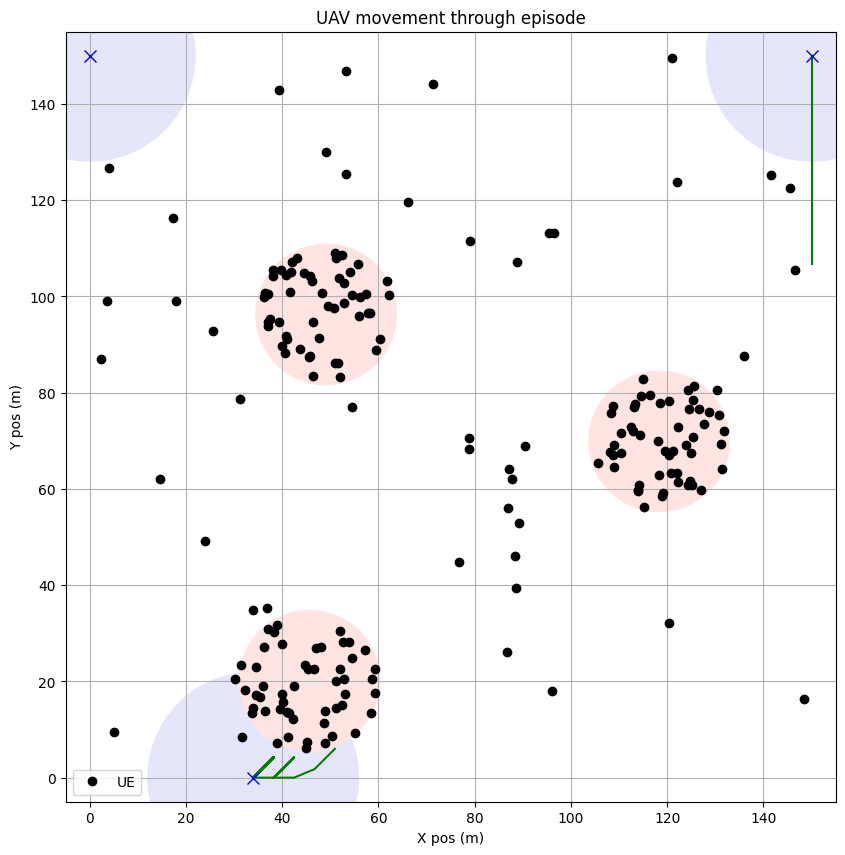

In [24]:
def run_random_episode():
  
  state = env.reset()
  # print("beginning state: ", state[0])
  done = False
  UAV_positions_list = [state.numpy()[0]]
  while not done:
    # print(state.numpy())
    action = torch.tensor([[[policy(state=torch.flatten(state, end_dim=-1), epsilon=0., UAV_index=i)] for i in range(env.UAV_count)]])
    np_action = [act.item() for act in action[0]]
    print(np_action)
    # action = policy(state, epsilon=0.)
    # print("action: ", action)
    new_state, reward, done, _ = env.step(np_action)
    # print("new_state: ", new_state[0][:2])
    state = new_state
    UAV_positions_list.append(state.numpy()[0])

  UAV_positions_list = np.array(UAV_positions_list)
  # print(UAV_positions_list)
  # print(UAV_positions_list[:, 0, 0])
  env.render_UAV_movement_through_episode(UAV_positions_list = UAV_positions_list)
  return

run_random_episode()

In [25]:
env.get_count_of_UEs_covered()

24

## Show results

### Plot execution stats

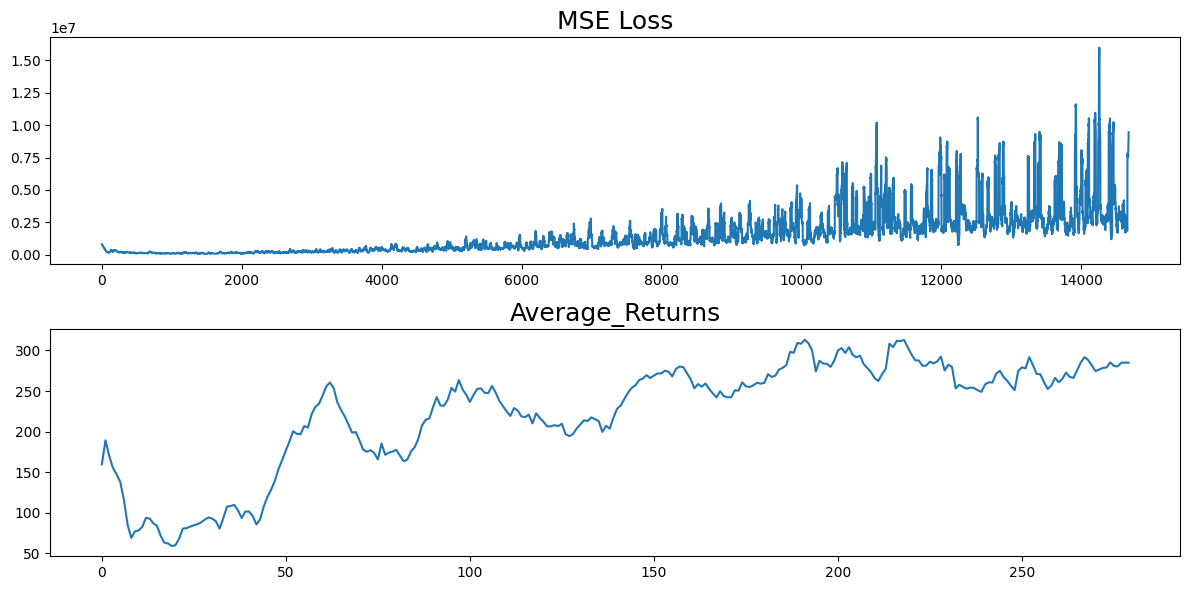

In [26]:
plot_stats1(stats)

### Test the resulting agent

In [ ]:
test_agent(env, policy, episodes=2)

NameError: ignored

In [ ]:
env.close()

#Trash

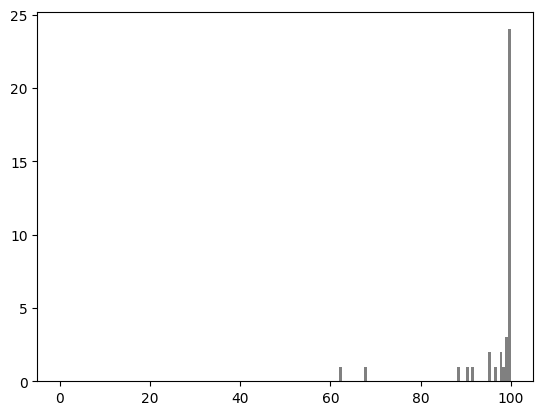

In [ ]:
import matplotlib.pyplot as plt

ls = [100.0, 97.71468590788739, 100.0, 90.20310184727836, 100.0, 99.9807159721745, \
    100.0, 91.83619157234803, 96.84593377931832, 99.86729696677925, 100.0, \
    98.92288465866825, 67.56989771799269, 99.83987432491959, 99.59146585463486, \
    100.0, 98.98334612401706, 100.0, 100.0, 100.0, 62.18123349512672, 99.2619241988031, \
    97.55065082008623, 95.50112195207895, 100.0, 100.0, 100.0, 100.0, 100.0, \
    99.8929108599519, 95.2757281046626, 100.0, 99.69976668780754, 100.0, 100.0, \
    98.49650425768503, 88.25113160956573, 99.97177575781565]
plt.hist(ls, bins=160, range=[0, 100], facecolor='gray', align='mid')
plt.show()